# Path decomposition

Monia Lupparelli & Giovanni M. Marchetti

22-12-2023

## Example of Application of section 6
The vertices of the graph represent items of an industrial network (servers, firewalls, computers, devices), able to monitoring the industrial equipments, assets and processes. 

### Structure of the network

The network is defined by an undirected graph starting with an adjacency matrix and then using the R package `igraph`.


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




IGRAPH 5118dfb UN-- 9 12 -- 
+ attr: name (v/c)
+ edges from 5118dfb (vertex names):
 [1] A--B A--C B--H C--D C--E C--F D--E D--F E--F F--G G--I H--I

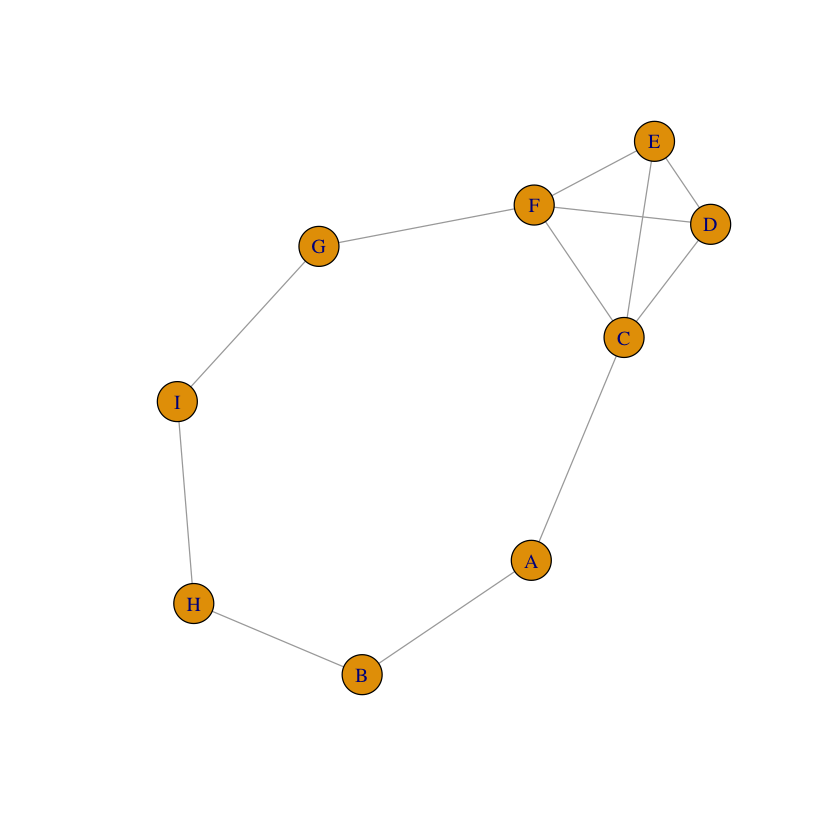

In [1]:
library("igraph")
G <- matrix(c(
    0, 1, 1, 0, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0, 0, 1, 0,
    1, 0, 0, 1, 1, 1, 0, 0, 0,
    0, 0, 1, 0, 1, 1, 0, 0, 0,
    0, 0, 1, 1, 0, 1, 0, 0, 0,
    0, 0, 1, 1, 1, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 0, 0, 1,
    0, 1, 0, 0, 0, 0, 0, 0, 1,
    0, 0, 0, 0, 0, 0, 1, 1, 0
), 9, 9)
V <- c("A", "B", "C", "D", "E", "F", "G", "H", "I")
dimnames(G) <- list(V, V)
G <- graph_from_adjacency_matrix(G, mode = "undirected")
G
plot(G)


### Definition of an Ising joint probability distribution

The distribution for the 9 binary variables associated with the nodes of the graph is assumed to be 
an Ising model defined by  
$$
p(x)  \propto \exp(\textstyle\frac{1}{2} x^T A x + x^T b), \quad x\in \{0,1\}^9
$$
where $A$ is a $9 \times 9$ symmetric matrix with entries $a_{ij}$ 
with a diagonal of zeros and $b$ is $9\times 1$ real vector with elements $b_j$. 
The Ising distribution is Markov with respect to the network $G$ if $a_{ij} = 0$ 
whenever the edge $i \sim j$ is missing. 

The functions of file `path_functions.R` are needed. Here the function`ising()` yields a 
$2^9$ vector `p` of the joint probabilities. 


In [2]:
X <- data.frame(expand.grid(rep(list(c(0, 1)), 9)))
colnames(X) <- V
v <- length(V)

A <- matrix(c(
  0, .2, .8, 0, 0, 0, 0, 0, 0,
  .2, 0, 0, 0, 0, 0, 0, .8, 0,
  .8, 0, 0, .4, .6, .9, 0, 0, 0,
  0, 0, .4, 0, .3, .2, 0, 0, 0,
  0, 0, .6, .3, 0, .5, 0, 0, 0,
  0, 0, .9, .2, .5, 0, .7, 0, 0,
  0, 0, 0, 0, 0, .7, 0, 0, .8,
  0, .8, 0, 0, 0, 0, 0, 0, .9,
  0, 0, 0, 0, 0, 0, .8, .9, 0
), 9, 9)
dimnames(A) <- list(V, V)
b <- c(0.1, 0.3, -0.2, 0.1, 0.1, 0.2, -0.6, 0.1, 0.2)

ising <- function(A, b) {
  v <- ncol(A)
  X <- data.matrix(expand.grid(rep(list(c(0, 1)), v)))
  p <- rep(0, 2^v)
  for (i in 1:(2^v)) {
    p[i] <- exp((1 / 2) * X[i, , drop = FALSE] %*% A %*% t(X[i, , drop = FALSE]) + X[i, ] %*% b)
  }
  p / sum(p)
}

p <- ising(A, b) 
length(p)

ERROR: Error in ising_gen(A, b): could not find function "ising_gen"


In [13]:
X[1,, drop = FALSE] %*% A
A

ERROR: Error in X[1, , drop = FALSE] %*% A: requires numeric/complex matrix/vector arguments


Below the first 6 cells of the true contingency table. 

In [86]:
head(data.frame(X, prob = p))

,A,B,C,D,E,F,G,H,I,prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,7.398215e-05
2,1,0,0,0,0,0,0,0,0,8.176292e-05
3,0,1,0,0,0,0,0,0,0,9.986546e-05
4,1,1,0,0,0,0,0,0,0,1.348043e-04
5,0,0,1,0,0,0,0,0,0,6.057146e-05
6,1,0,1,0,0,0,0,0,0,1.489818e-04


### Finding the log-linear parameters
Fitting the Poisson log-linear model containing only the 
two-factor interactions corresponding to the edges of the graph returns the parameters $\alpha_{ij}$ contained in the 
matrix $A$. 

In [87]:
options(warn = -1)
m <- glm(Freq ~ A * (B + C) + B * H + C * (D + E + F) + D * (E + F) + E * F + F * G + G * I + I * H, family = poisson, data = data.frame(X, Freq = p))
a <- coef(m)
round(a, 3)


(Intercept)           A           B           C           H           D 
     -9.512       0.100       0.300      -0.200       0.100       0.100 
          E           F           G           I         A:B         A:C 
      0.100       0.200      -0.600       0.200       0.200       0.800 
        B:H         C:D         C:E         C:F         D:E         D:F 
      0.800       0.400       0.600       0.900       0.300       0.200 
        E:F         F:G         G:I         H:I 
      0.500       0.700       0.800       0.900

The conditional odds-ratios are $\psi_{ij} = \exp(\alpha_{ij})$.

In [88]:
psi <- exp(a)
psi[-1]


A         B         C         H         D         E         F         G 
1.1051709 1.3498588 0.8187308 1.1051709 1.1051709 1.1051709 1.2214028 0.5488116 
        I       A:B       A:C       B:H       C:D       C:E       C:F       D:E 
1.2214028 1.2214028 2.2255409 2.2255409 1.4918247 1.8221188 2.4596031 1.3498588 
      D:F       E:F       F:G       G:I       H:I 
1.2214028 1.6487213 2.0137527 2.2255409 2.4596031

### Find all paths from B and F
Use a specific function from package **igraph**:

In [89]:
path_list <- all_simple_paths(G, "B", "F")
path_list <- lapply(path_list, as_ids)
path_list


[[1]]
[1] "B" "A" "C" "D" "E" "F"

[[2]]
[1] "B" "A" "C" "D" "F"

[[3]]
[1] "B" "A" "C" "E" "D" "F"

[[4]]
[1] "B" "A" "C" "E" "F"

[[5]]
[1] "B" "A" "C" "F"

[[6]]
[1] "B" "H" "I" "G" "F"

If needed we can transform the list of paths into a list `pa` of integer vectors. 

In [90]:
fun <- function(u) match(u, LETTERS[1:9])
pa <- lapply(path_list, fun)
pa


[[1]]
[1] 2 1 3 4 5 6

[[2]]
[1] 2 1 3 4 6

[[3]]
[1] 2 1 3 5 4 6

[[4]]
[1] 2 1 3 5 6

[[5]]
[1] 2 1 3 6

[[6]]
[1] 2 8 9 7 6

The length of the paths are stored in vector `size`.

In [91]:
size <- sapply(path_list, length)
size


[1] 6 5 6 5 4 5

The edge odds-ratios can be  found by indexing the vector $\psi$ (see above). For 
instance $\psi_{AB}$ is

In [92]:
psi["A:B"]


A:B 
1.221403

### Covariance matrix of the (estimated) vector $\psi$
Here we assume that $\alpha = \log \psi$ is an estimator. 
The covariance matrix `S` of the estimates $\alpha$ can be found as
follows (we give a submatrix of the first two interactions)

In [93]:
S <- vcov(m)
round(S[11:12, 11:12], 8)


,A:B,A:C
A:B,24.5912355,-0.0023506
A:C,-0.0023506,33.8409936


The covariance matrix of $\psi = \exp(\alpha)$ can be calculated with the delta method

In [94]:
S_psi <- diag(exp(a)) %*% S %*% diag(exp(a))
round(S_psi[11:12, 11:12], 9)


36.685812487,-0.006389582
-0.006389582,167.615538415


### List of the edge odds-ratios for each path 

In [95]:
for (h in seq_along(path_list)) {
    w <- path_list[[h]]
    ed <- c()
    for (i in 2:size[h]) {
        ed <- c(ed, exp(A[w[i - 1], w[i]]))
    }
    cat("Path", h, "\n")
    cat(round(ed, 2), "omega: ", round(prod(ed), 2), "\n")
}


Path 1 
1.22 2.23 1.49 1.35 1.65 omega:  9.03 
Path 2 
1.22 2.23 1.49 1.22 omega:  4.95 
Path 3 
1.22 2.23 1.82 1.35 1.22 omega:  8.17 
Path 4 
1.22 2.23 1.82 1.65 omega:  8.17 
Path 5 
1.22 2.23 2.46 omega:  6.69 
Path 6 
2.23 2.46 2.23 2.01 omega:  24.53 


#### Definition of $Y_\delta$

An example with 5 nodes and a single path $(a=1, \delta = 3, b = 2)$.

Note that by default $a = 1$ and $b = 2$, `delta` is the vector of path inner nodes (can be empty), `v` is the number of nodes. The number of nodes of the graph must be $> 3$.

In [96]:
`ydelta` <- function(delta, v, a=1, b = 2) {
  if (v < 3) stop("The number of nodes is less then 3.")
  pat <- c(a, delta, b) 
  rest <- setdiff(1:v, c(a, delta, b))
  rest <- as.vector(rest)

  X <- expand.grid(rep(list(c(0, 1)), v))
  colnames(X) <- paste0("X", 1:v)

  Ydelta <- matrix(0, nrow = 2^v, ncol = 2)
  for (i in 1:2^v) {
    Ydelta[i, ] <- c(
      all(X[i, delta] == 1),
      all(X[i, rest] == 0)
    )
  }
  Yd <- matrix(0, nrow = 2^v, ncol = 1)

  for (i in 1:2^v) {
    if (Ydelta[i, 1] == 1 & Ydelta[i, 2] == 1) {
      Yd[i] <- 1
    } else {
      Yd[i] <- 0
    }
  }
cbind(X, Yd, Ydelta)
}

In [97]:
delta <- c(3)
v <- 5
ydelta(delta, v)

X1,X2,X3,X4,X5,Yd,1,2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1
0,0,1,0,0,1,1,1
1,0,1,0,0,1,1,1
0,1,1,0,0,1,1,1
1,1,1,0,0,1,1,1
0,0,0,1,0,0,0,0


Example with 3 nodes and a single path $(a = 1, \delta = 3, b = 2)$.

In [98]:
delta <- c(3)
v <- 3
ydelta(delta, v)

X1,X2,X3,Yd,1,2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,1
1,0,0,0,0,1
0,1,0,0,0,1
1,1,0,0,0,1
0,0,1,1,1,1
1,0,1,1,1,1
0,1,1,1,1,1
1,1,1,1,1,1


Example with 3 nodes and a single path $(a = 1, b = 2)$ and $\delta = \emptyset$.

In [99]:
delta <- c()
v <- 3
ydelta(delta, v)

X1,X2,X3,Yd,1,2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,1,1,1
1,0,0,1,1,1
0,1,0,1,1,1
1,1,0,1,1,1
0,0,1,0,1,0
1,0,1,0,1,0
0,1,1,0,1,0
1,1,1,0,1,0


Example with 5 nodes and a single path $(a = 1, \delta=(3,4), b = 2)$.

In [100]:
delta <- c(3,4)
v <- 5
ydelta(delta, v)

X1,X2,X3,X4,X5,Yd,1,2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1
0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,1
0,1,1,0,0,0,0,1
1,1,1,0,0,0,0,1
0,0,0,1,0,0,0,1


#### Joint distribution of $X_a, X_b , Y_\delta$.

Example 1: $\delta = 3$, $v = 5$.

In [108]:
`dis3` <- function(delta, v) {
    R <- ydelta(delta, v)
    cbind(R[, 1:2], Yd = R$Yd)
}


In [109]:
dis3(3, 5)
table(dis3(3,5))

X1,X2,Yd
<dbl>,<dbl>,<dbl>
0,0,0
1,0,0
0,1,0
1,1,0
0,0,1
1,0,1
0,1,1
1,1,1
0,0,0


, , Yd = 0

   X2
X1  0 1
  0 7 7
  1 7 7

, , Yd = 1

   X2
X1  0 1
  0 1 1
  1 1 1


Example 2: $\delta = 3$, $v = 3$.

In [110]:
table(dis3(3,3))

, , Yd = 0

   X2
X1  0 1
  0 1 1
  1 1 1

, , Yd = 1

   X2
X1  0 1
  0 1 1
  1 1 1


Example 3: $\delta = \emptyset$, $v = 3$.

In [111]:
table(dis3(c(),3))

, , Yd = 0

   X2
X1  0 1
  0 1 1
  1 1 1

, , Yd = 1

   X2
X1  0 1
  0 1 1
  1 1 1


Example 4: $\delta = (3,4)$, $v = 5$

In [112]:
table(dis3(c(3,4),5))

, , Yd = 0

   X2
X1  0 1
  0 7 7
  1 7 7

, , Yd = 1

   X2
X1  0 1
  0 1 1
  1 1 1


### Path-based decomposition

In [20]:
`path_analysis` <- function(pa, v, X, p) {
  Gamma <- matrix(0, nrow = length(pa), ncol = 1)
  Theta <- Gamma
  Delta <- Gamma
  OR <- Gamma
  Y <- Gamma

  for (d in 1:length(pa)) {
    a <- pa[[d]][1]
    b <- pa[[d]][length(pa[[d]])]
    if (a == b) {
      stop("Paths endpoints are different!")
    }

    delta <- setdiff(pa[[d]], c(a, b))
    rest <- setdiff(1:v, c(a, delta, b))
    rest <- as.vector(rest)

    num <- matrix(0, nrow = 2^v, ncol = 1)
    for (i in 1:2^v) {
      if (X[i, a] == 1 & X[i, b] == 1 &
        all(X[i, delta] == 1) & all(X[i, rest] == 0)) {
        num[i] <- 1
      } else {
        num[i] <- 0
      }
    }

    data_ <- data.frame(X, prob = p)
    Gamma[d] <- data_[which(num == 1), v + 1]

    Ydelta <- matrix(0, nrow = 2^v, ncol = 2)

    for (i in 1:2^v) {
      Ydelta[i, ] <- c(
        all(X[i, delta] == 1),
        all(X[i, rest] == 0)
      )
    }

    Yd <- matrix(0, nrow = 2^v, ncol = 1)

    for (i in 1:2^v) {
      if (Ydelta[i, 1] == 1 & Ydelta[i, 2] == 1) {
        Yd[i] <- 1
      } else {
        Yd[i] <- 0
      }
    }

    X.d <- cbind(X[, c(a, b)], Yd)
    X.dd <- unique(X.d)
    data.d <- as.data.frame(cbind(X.d, p))
    tab.d <- xtabs(p ~ ., data.d)
    prob.d <- c(
      tab.d[1, 1, 1], tab.d[1, 1, 2],
      tab.d[1, 2, 1], tab.d[1, 2, 2],
      tab.d[2, 1, 1], tab.d[2, 1, 2],
      tab.d[2, 2, 1], tab.d[2, 2, 2]
    )

    Freq.d <- prob.d #* n
    data.ddd <- data.frame(X.dd, Freq.d)
    m.d <- glm(Freq.d ~ B * F * V3,
      family = poisson,
      data = data.ddd
    )
    # options(scipen = 100)
    print(summary(m.d)$coef, digits = 2)

   browser() 
    Theta[d] <- tab.d[2, 2, 1]
    Delta[d] <- Gamma[d] / (Gamma[d] + Theta[d])

    Z.d <- matrix(0, nrow = 2^v, ncol = 2)
    adb <- c(a, b, delta)

    for (i in 1:2^v) {
      Z.d[i, 1] <- c(all(X[i, adb] == 1))
      Z.d[i, 2] <- c(all(X[i, rest] == 1))
    }

    data.Z <- cbind(Z.d, p)
    Z.dd <- unique(Z.d)
    tab.Z <- xtabs(p ~ ., data.Z)
    prob.Z <- c(tab.Z[1, 1], tab.Z[1, 2], tab.Z[2, 1], tab.Z[2, 2])
    Freq.Z <- prob.Z #* n
    data.ZZ <- as.data.frame(cbind(Z.dd, Freq.Z))
    OR[d] <- (tab.Z[1, 1] * tab.Z[2, 2]) / (tab.Z[2, 1] * tab.Z[1, 2])

    # m.Z = glm(Freq.Z ~ V1*V2, family = poisson, data = data.ZZ)
    # options(scipen = 100)
    # print(summary(m.Z)$coef, digits = 2)

    # Yule's measure
    Y[d] <- (sqrt(OR[d]) - 1) / (sqrt(OR[d]) + 1)
  }

  data.frame(Gamma, Theta,
    P_ = Delta / sum(Delta),
    OR, Y_ = Y / sum(Y)
  )
}


function (...) 
constructor_spec(sample_pa, ...)
<bytecode: 0x10c8b3190>
<environment: namespace:igraph>

In [107]:
x <- path_analysis(pa, v,  X, p)
round(x, 3)

ERROR: Error in Gamma[d] <- data_[which(num == 1), v + 1]: replacement has length zero
